# 05_test_on_unseen_data.ipynb

# Imports Lib


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Load Data


In [32]:
data_path = "../data/processed/sp500_cleaned_model_ready.csv"
df = pd.read_csv(data_path, index_col=0, parse_dates=True)
print(f" Loaded dataset: {df.shape}")

# Define features
features = [col for col in df.columns if col not in ["Tomorrow", "Target"]]
target = "Target"

 Loaded dataset: (7872, 45)


# Define unseen data (2024–)


In [33]:
unseen_cutoff = "2024-01-01"
df_unseen = df[df.index >= unseen_cutoff].copy()
X_unseen = df_unseen[features]
y_true = df_unseen[target]

print(f" Unseen data from {unseen_cutoff}: {X_unseen.shape} rows")

 Unseen data from 2024-01-01: (307, 44) rows


# 4) Load best model


In [34]:
model_path = "../models/best_model_RandomForest.pkl"  # or best_model_XGBoost.pkl
model = joblib.load(model_path)
print(f" Loaded model: {model_path}")

 Loaded model: ../models/best_model_RandomForest.pkl


# 5) Predict on unseen data

In [35]:
y_proba = model.predict_proba(X_unseen)[:, 1]  # probability of class=1
threshold = 0.5
y_pred = (y_proba > threshold).astype(int)

precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print("\n=== Performance on Unseen Data ===")
print(f"Threshold = {threshold}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))



=== Performance on Unseen Data ===
Threshold = 0.5
Precision: 0.9558
Recall:    0.6207
F1 Score:  0.7526

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.96      0.78       133
           1       0.96      0.62      0.75       174

    accuracy                           0.77       307
   macro avg       0.81      0.79      0.77       307
weighted avg       0.83      0.77      0.77       307



# Confidence Distribution


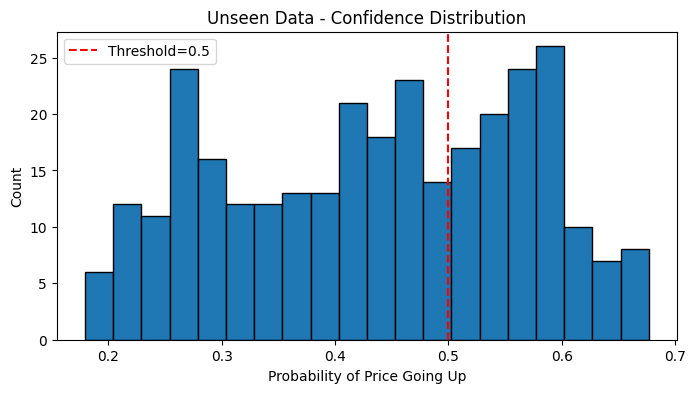

In [36]:
os.makedirs("../reports/images/model", exist_ok=True)

plt.figure(figsize=(8, 4))
plt.hist(y_proba, bins=20, edgecolor="black")
plt.axvline(threshold, color="red", linestyle="--", label=f"Threshold={threshold}")
plt.title("Unseen Data - Confidence Distribution")
plt.xlabel("Probability of Price Going Up")
plt.ylabel("Count")
plt.legend()
plt.savefig("../reports/images/model/unseen_confidence_hist.png")
plt.show()

# Actual vs Predicted Plot


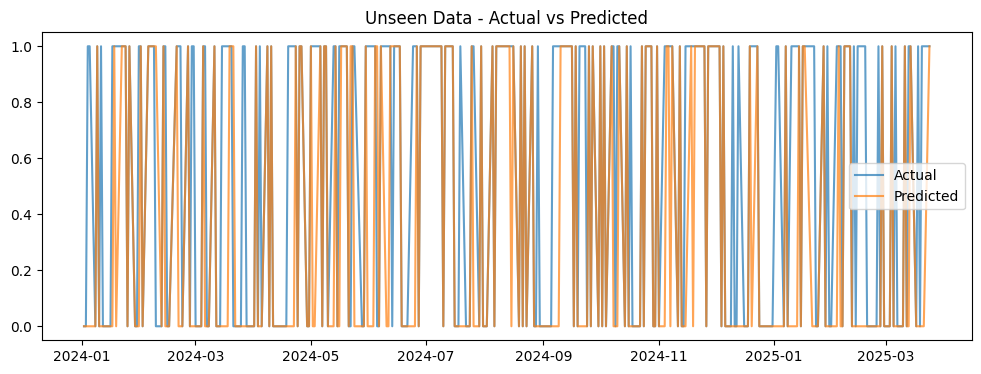

In [37]:
df_unseen["Prediction"] = y_pred
df_unseen["Prob_Up"] = y_proba

plt.figure(figsize=(12, 4))
plt.plot(df_unseen.index, df_unseen[target], label="Actual", alpha=0.7)
plt.plot(df_unseen.index, df_unseen["Prediction"], label="Predicted", alpha=0.7)
plt.title("Unseen Data - Actual vs Predicted")
plt.legend()
plt.savefig("../reports/images/model/unseen_prediction_vs_actual.png")
plt.show()

# (Optional) Threshold Sensitivity Test



=== Threshold Sensitivity on Unseen Data ===
   Threshold  Precision    Recall        F1
0       0.30   0.719665  0.988506  0.832930
1       0.35   0.790698  0.977011  0.874036
2       0.40   0.842105  0.919540  0.879121
3       0.45   0.895425  0.787356  0.837920
4       0.50   0.955752  0.620690  0.752613
5       0.55   0.974026  0.431034  0.597610
6       0.60   1.000000  0.166667  0.285714
7       0.65   1.000000  0.045977  0.087912


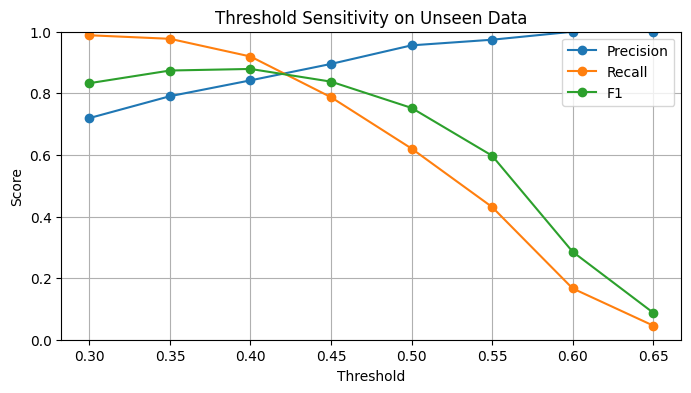

In [38]:
thresholds = np.arange(0.3, 0.7, 0.05)
sens_results = []
for t in thresholds:
    y_pred_t = (y_proba > t).astype(int)
    prec_t = precision_score(y_true, y_pred_t, zero_division=0)
    rec_t = recall_score(y_true, y_pred_t, zero_division=0)
    f1_t = f1_score(y_true, y_pred_t, zero_division=0)
    sens_results.append({"Threshold": t, "Precision": prec_t, "Recall": rec_t, "F1": f1_t})

sens_df = pd.DataFrame(sens_results)
print("\n=== Threshold Sensitivity on Unseen Data ===")
print(sens_df)

plt.figure(figsize=(8, 4))
plt.plot(sens_df["Threshold"], sens_df["Precision"], marker='o', label="Precision")
plt.plot(sens_df["Threshold"], sens_df["Recall"], marker='o', label="Recall")
plt.plot(sens_df["Threshold"], sens_df["F1"], marker='o', label="F1")
plt.title("Threshold Sensitivity on Unseen Data")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.savefig("../reports/images/model/unseen_threshold_sensitivity.png")
plt.show()

# Save predictions (optional)


In [39]:
df_unseen.to_csv("../data/processed/unseen_test_predictions.csv")
print("\n Unseen data predictions saved to ../data/processed/unseen_test_predictions.csv")

print("\n Test on unseen data complete!")


 Unseen data predictions saved to ../data/processed/unseen_test_predictions.csv

 Test on unseen data complete!
